In [1]:
import tensorflow as tf
import glob
import cv2
import os

# Enable mixed precision if supported
tf.keras.mixed_precision.set_global_policy('mixed_float16')

# Set custom configurations
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)

# Set environment variables to manage cuDNN behavior

os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

# Define data paths

test_images_folder_path = '/kaggle/input/airbus-ship-detection/test_v2'
test_images_filenames = [os.path.basename(filename) for filename in glob.glob(test_images_folder_path + '/*')]

unet_weights_path = '/kaggle/input/unet_model_sr08_dc_046/keras/default/1/unet_model_sr08_dc_046.weights.h5'

2024-07-30 07:29:18.768588: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-30 07:29:18.768715: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-30 07:29:18.914963: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from skimage.transform import resize
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, concatenate, Conv2DTranspose, BatchNormalization

def UNet(input_shape=(256, 256, 3)):
    inputs = Input(input_shape)
    
    # Downsampling path
    conv1 = Conv2D(16, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(16, (3, 3), activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)
    
    conv2 = Conv2D(32, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)
    
    conv3 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    pool3 = MaxPooling2D((2, 2))(conv3)
    
    conv4 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D((2, 2))(drop4)
    
    # Upsampling path
    up5 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(pool4)
    up5 = concatenate([up5, drop4], axis=3)
    conv5 = Conv2D(128, (3, 3), activation='relu', padding='same')(up5)
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv5)
    conv5 = BatchNormalization()(conv5)
    
    up6 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv5)
    up6 = concatenate([up6, conv3], axis=3)
    conv6 = Conv2D(64, (3, 3), activation='relu', padding='same')(up6)
    conv6 = BatchNormalization()(conv6)
    conv6 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv6)
    conv6 = BatchNormalization()(conv6)
    
    up7 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv6)
    up7 = concatenate([up7, conv2], axis=3)
    conv7 = Conv2D(32, (3, 3), activation='relu', padding='same')(up7)
    conv7 = BatchNormalization()(conv7)
    conv7 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv7)
    conv7 = BatchNormalization()(conv7)
    
    up8 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(conv7)
    up8 = concatenate([up8, conv1], axis=3)
    conv8 = Conv2D(16, (3, 3), activation='relu', padding='same')(up8)
    conv8 = BatchNormalization()(conv8)
    conv8 = Conv2D(16, (3, 3), activation='relu', padding='same')(conv8)
    conv8 = BatchNormalization()(conv8)
    
    # Final convolutional layer
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(conv8)
    
    model = Model(inputs=[inputs], outputs=[outputs])
    
    return model

model = UNet()
model.load_weights(unet_weights_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


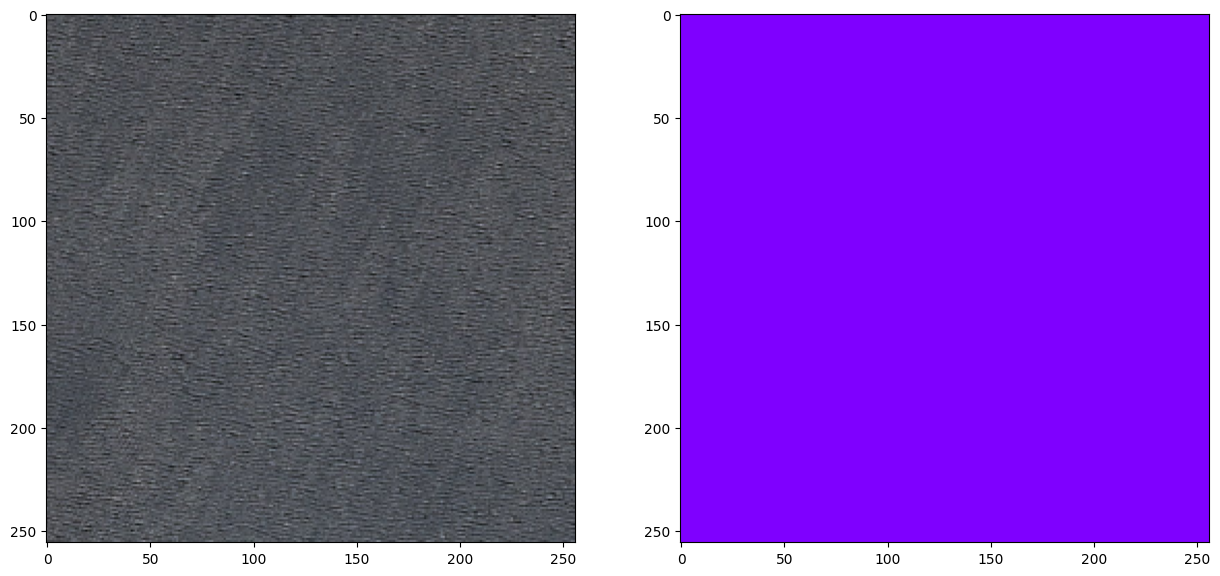

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


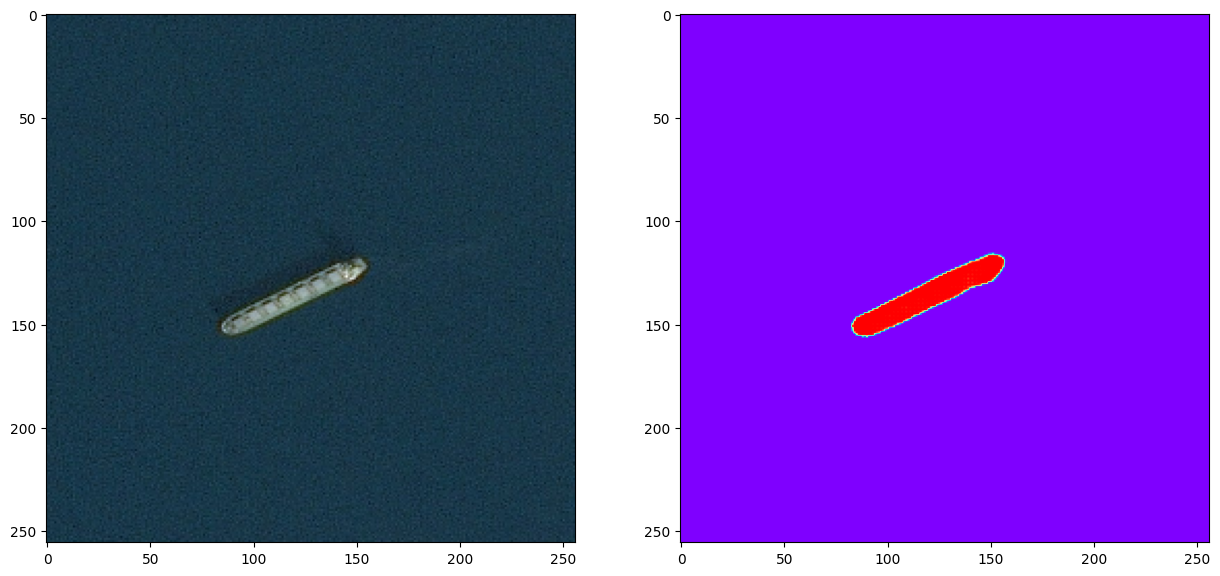

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


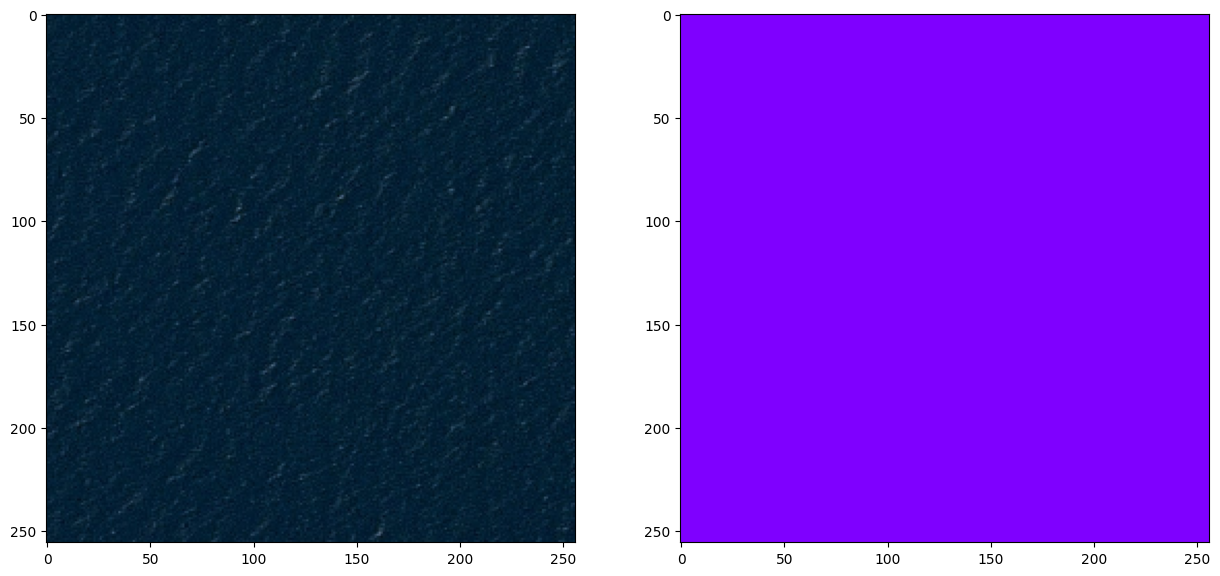

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


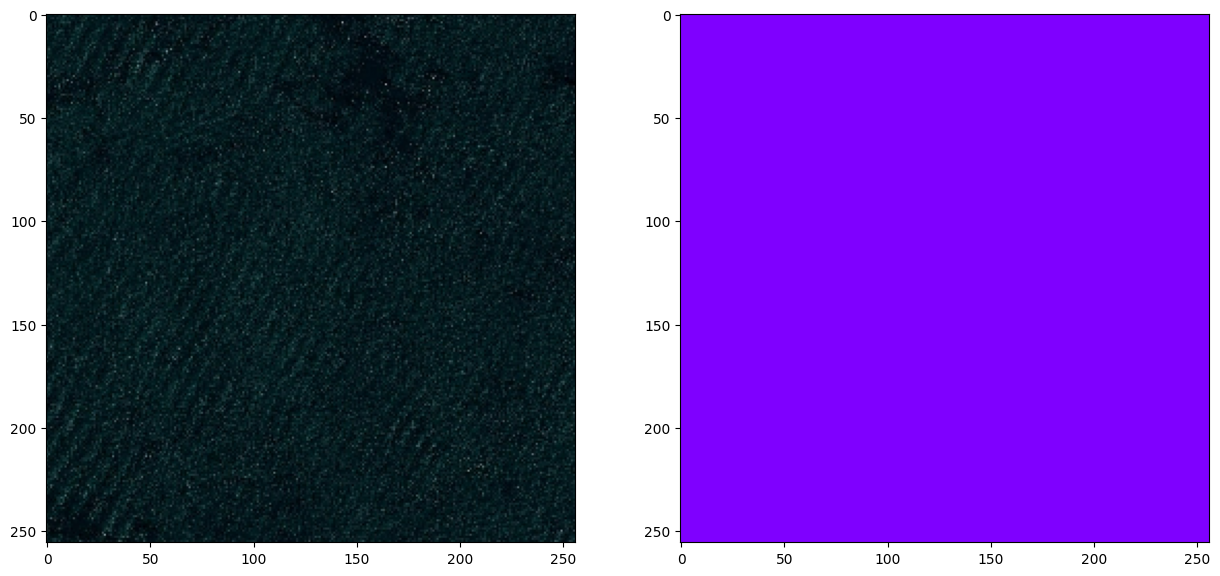

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


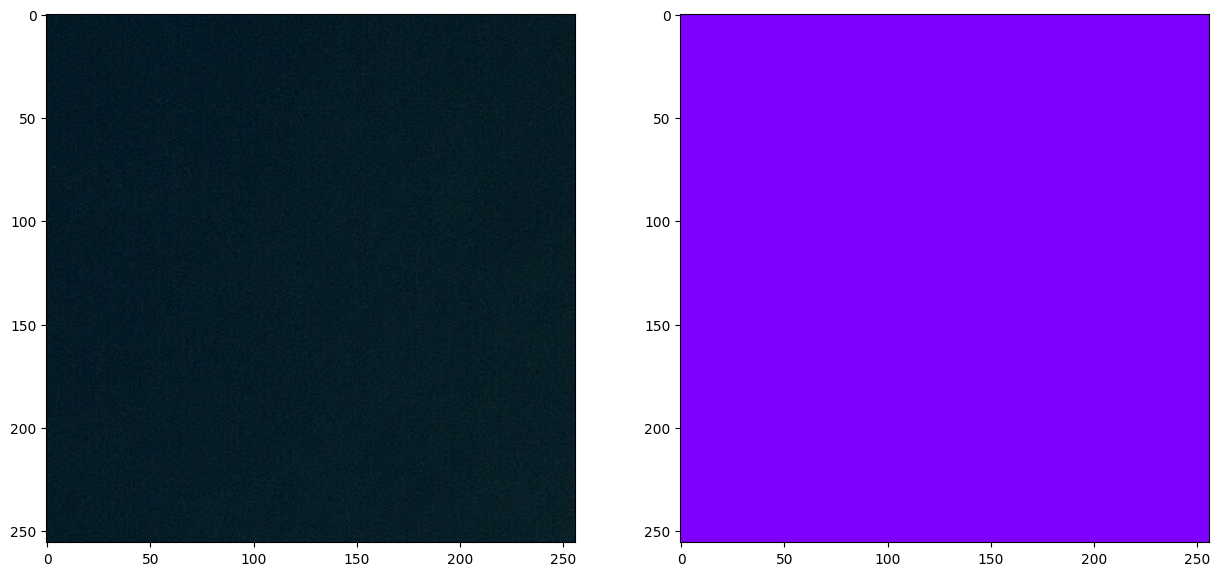

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


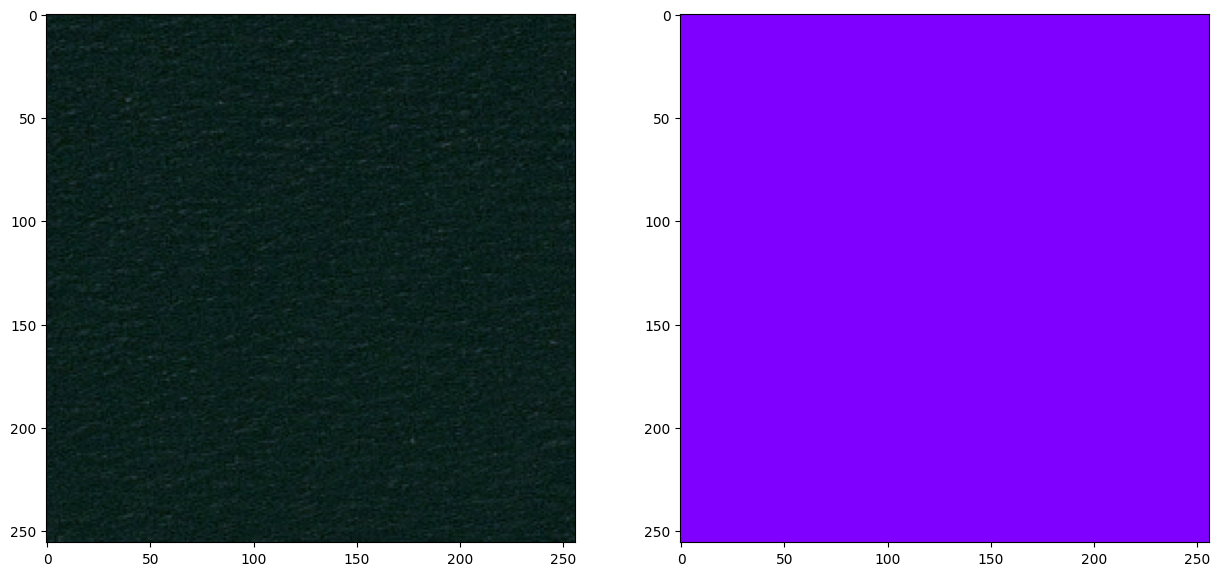

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


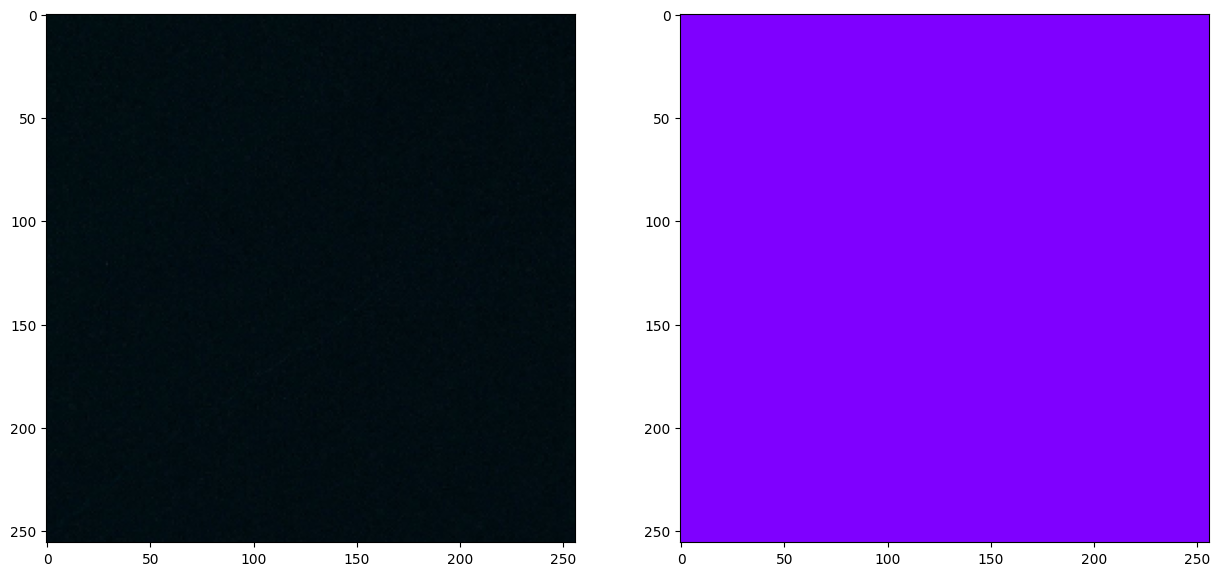

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


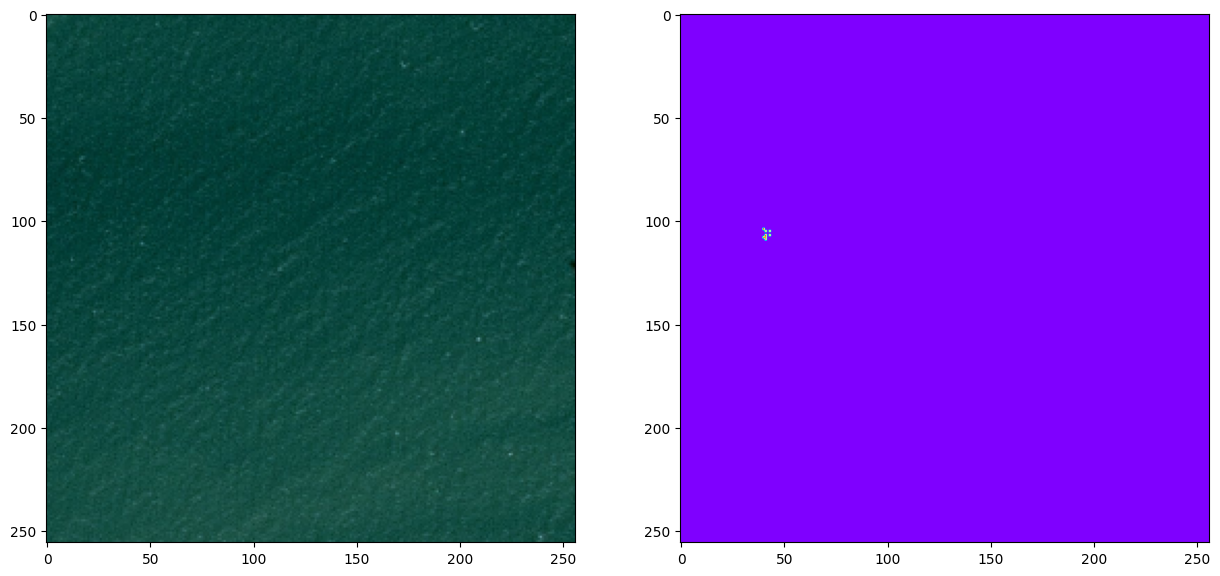

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


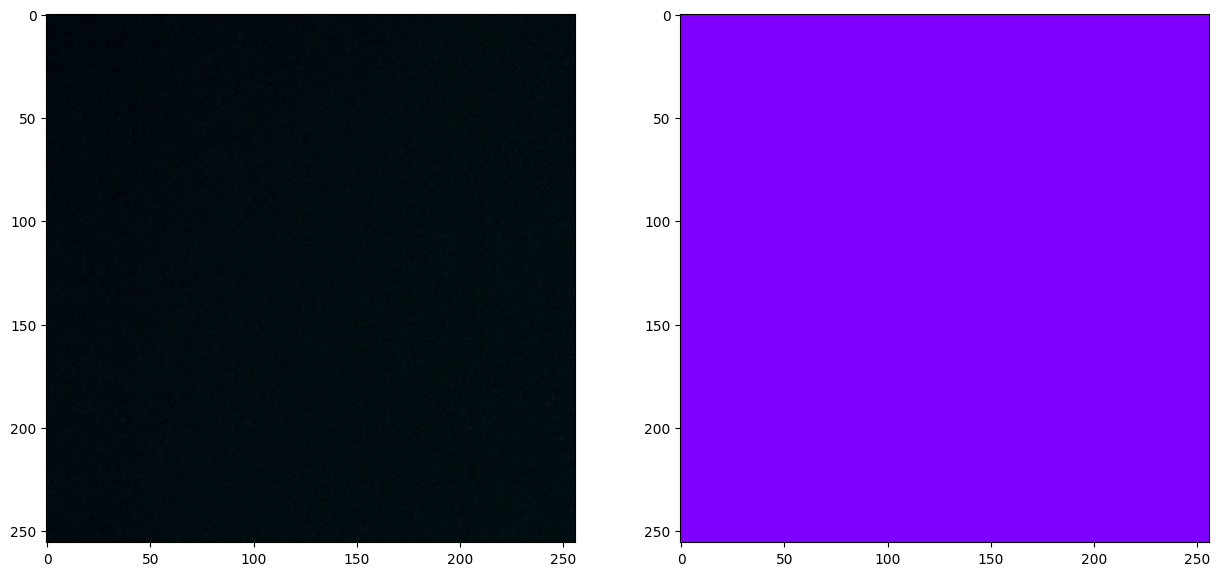

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


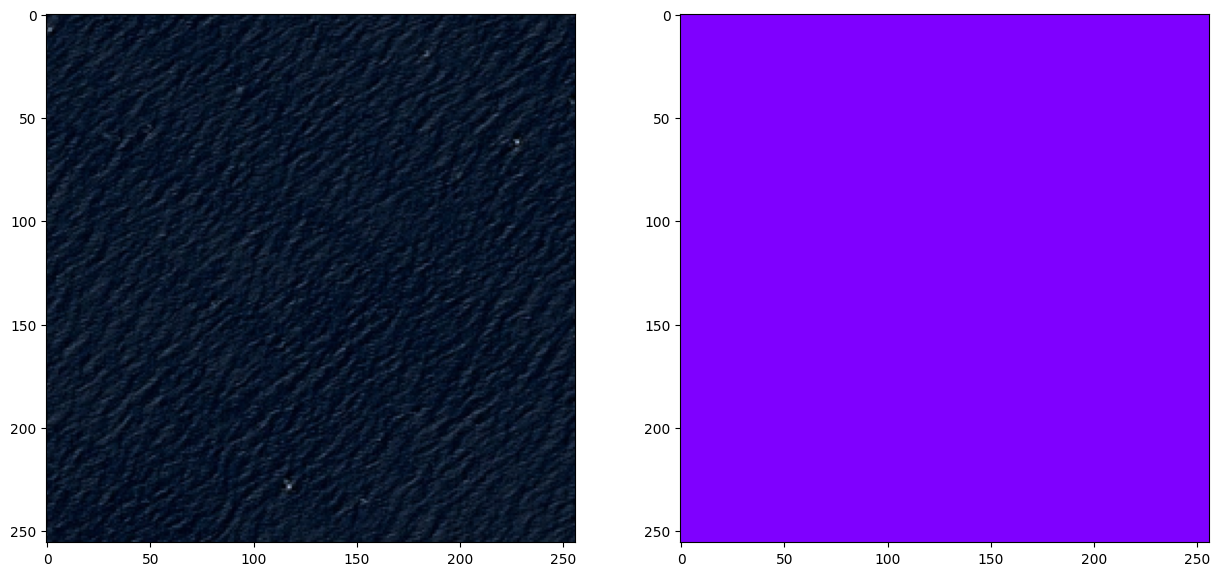

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


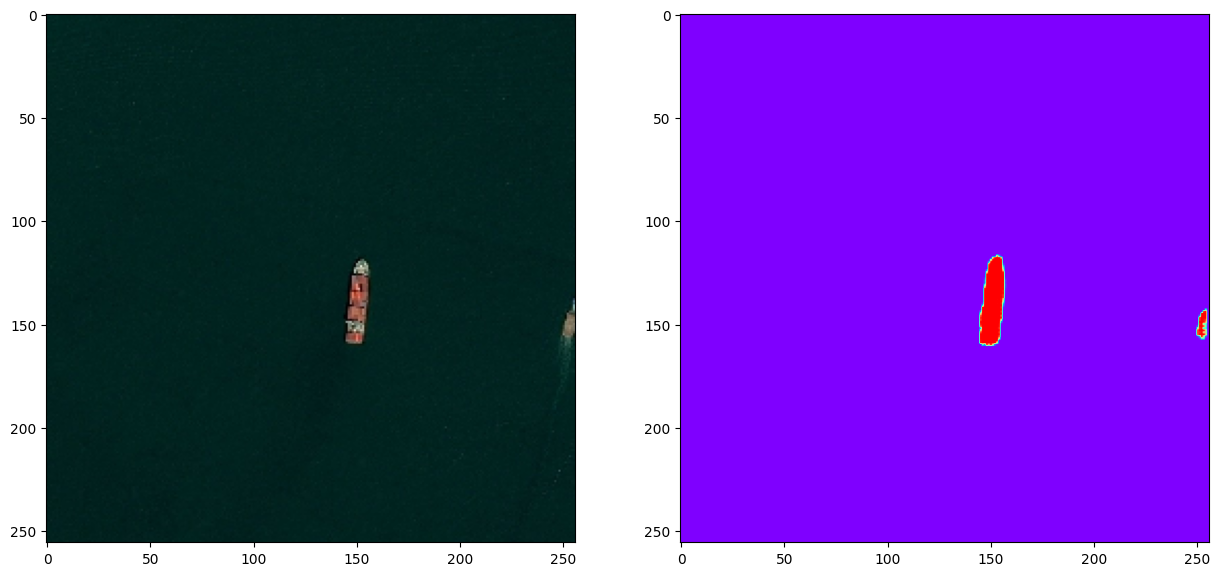

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


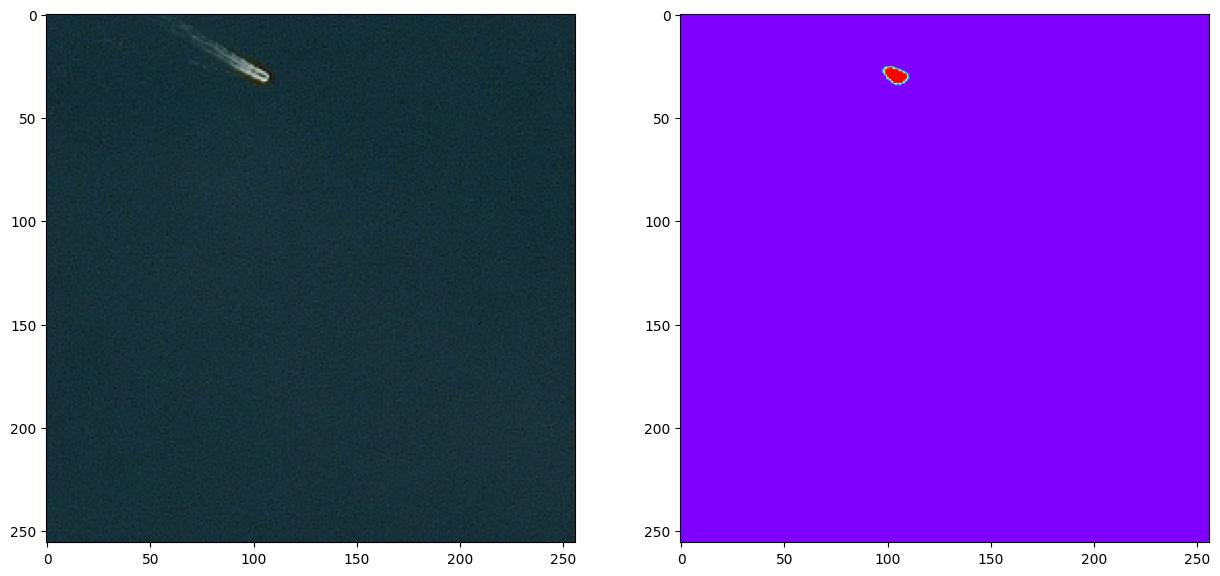

In [4]:
import matplotlib.pyplot as plt

def image_from_path(img_dir, img_name):
    img_path = os.path.join(img_dir, img_name)
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (256, 256)) 
    image = image / 255.0  
    return np.expand_dims(image, axis=0)

def make_prediction(model, image):
    prediction = model.predict(image).squeeze(0)
    return prediction

def display_image_and_prediction(image, prediction):
    fig, ax = plt.subplots(ncols=2, figsize=(15, 15))
    ax[0].imshow(image.squeeze(0))
    ax[1].imshow(prediction, cmap='rainbow')
    plt.show()

num_pairs = 12

# Loop through the first `num_pairs` images
for i in range(num_pairs):
    img_name = test_images_filenames[i]
    some_image = image_from_path(test_images_folder_path, img_name)
    some_prediction = make_prediction(model, some_image)
    display_image_and_prediction(some_image, some_prediction)